In [95]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import time
from astropy.io import fits
import ligo.skymap.plot
import healpy
import sys

In [96]:
path = '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/process_dag/bayestar-localize-coincs/10000/'
file = path + '1000003270.fits'   # size (196608,) 786432 = 4 * 196608
# file = path + '1000002729.fits'   # (786432,)
# file = path + '1000037550.fits'   # (786432,)
# file = path + '1000005369.fits'   # (786432,)
# file = '/Users/yunlin/Downloads/bayestar_no_virgo.fits'
header0 = fits.open(file)[0].header
header1 = fits.open(file)[1].header
data = fits.open(file)[1].data

In [97]:
# print(header0)
# print(header1)

In [98]:
par_label = ['PROBDENSITY', 'DISTMU  ', 'DISTSIGMA', 'DISTNORM', 'UNIQ    ']
# par = data['PROBDENSITY']
par = data[par_label[1]]
print(np.shape(par))

(19200,)


In [99]:
import astropy_healpix as ah
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy import units as u
from ligo.skymap.io import fits   # 'ligo.skymap.io.fits' has no attribute 'open'
                                  # 'astropy.io.fits' has no 'read_sky_map'
# import fits
# from fits import read_sky_map

## Problems to solve

* <font color='red'> Why `skymap` arrays have $4$ different shapes `(12582912,), (3145728,), (786432,), (196608,)`? </font>

## Test plotting skymap

In [30]:
def read_skymap(file):

    from ligo.skymap.io import fits
    skymap, metadata = fits.read_sky_map(file)

    # print(metadata.keys())   
        # odict_keys(['HISTORY', 'objid', 'instruments',  'gps_time', 
        # 'gps_creation_time', 'creator', 'origin', 'runtime', 'distmean', 
        # 'diststd', 'log_bci', 'log_bsn', 'vcs_version', 'nest'])

    return skymap

def plot_skymap(skymap):
    
    nside = ah.npix_to_nside(len(skymap))

    # Convert sky map from probability to probability per square degree.
    deg2perpix = ah.nside_to_pixel_area(nside).to_value(u.deg**2)
    probperdeg2 = skymap / deg2perpix

    # axes_args = {}
    # if opts.geo:
    #     axes_args['projection'] = 'geo'
    #     obstime = Time(metadata['gps_time'], format='gps').utc.isot
    #     axes_args['obstime'] = obstime
    # else:
    #     axes_args['projection'] = 'astro'
    # axes_args['projection'] += ' ' + opts.projection
    # if opts.projection_center is not None:
    #     axes_args['center'] = SkyCoord(opts.projection_center)
    # if opts.zoom_radius is not None:
    #     axes_args['radius'] = opts.zoom_radius
    
    ax = plt.axes(
        [0.05, 0.05, 0.9, 0.9],
        projection='astro mollweide')
    ax.grid()

    # Plot sky map.
    vmax = probperdeg2.max()

    img = ax.imshow_hpx(
        # nested=metadata['nest'], vmin=0., vmax=vmax
        # cmap='cylon',
        (probperdeg2, 'ICRS'), cmap='cylon', # nested=metadata['nest'],   # don't know what 'ICRS' is used for
        vmin=0., vmax=vmax)

# convert the skymap array to probability array
def prob_per_deg(skymap):
    
    nside = ah.npix_to_nside(len(skymap))

    # Convert sky map from probability to probability per square degree.
    deg2perpix = ah.nside_to_pixel_area(nside).to_value(u.deg**2)
    probperdeg2 = skymap / deg2perpix

    return probperdeg2

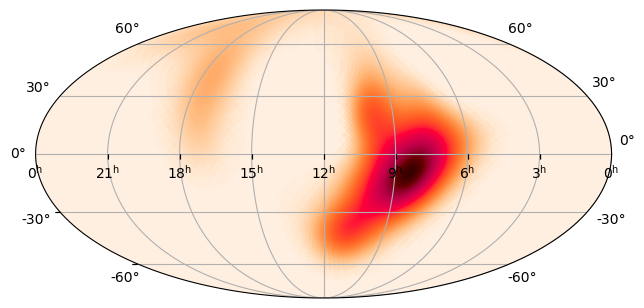

In [100]:
plot_skymap(read_skymap(file))

In [ ]:
def untrained_model():
    """Use this function for sanity check"""
    
    model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)
    x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
    pred = model(x)   # shape = (32, 100, 83), x.shape = (32, 100)

    # predictions from the untrained model
    
    sampled_indices = tf.random.categorical(pred[0], num_samples=1)
    sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

## Read SNR

In [32]:
import numpy as np
from ligo.lw import ligolw
from ligo.lw import lsctables
from ligo.lw import array as ligolw_array
from ligo.lw import param as ligolw_param
from ligo.lw import utils as ligolw_utils
from lal import series as lalseries
import lal

In [132]:
def read_snr(file):
    
    xmldoc = ligolw_utils.load_filename(file, 
        contenthandler=ligolw.LIGOLWContentHandler, verbose = True)
    
    Elem = xmldoc.getElementsByTagName(ligolw.LIGO_LW.tagName)
    elem = Elem[0] # this is the first detector (H1)

    t, = elem.getElementsByTagName(ligolw.Time.tagName)
    f0 = elem.getElementsByTagName(ligolw.Param.tagName)
    a, = elem.getElementsByTagName(ligolw.Array.tagName)  

    epoch = t.pcdata  ## this is t = 0

    dims = a.getElementsByTagName(ligolw.Dim.tagName)
    t_len = dims[0].n  ## this is length of the array
    deltaT = dims[0].Scale ## this is delta T between each array element

    s = a.getElementsByTagName(ligolw.Stream.tagName)
    lines = s[0].pcdata.split('\n')
    data = [l.split('\t')[4] for l in lines[1:-1]]
    time = [float(t.split(" ")[0]) for t in data]
    time = np.array(time)
    real = [float(d.split(" ")[1]) for d in data]
    real = np.array(real)
    imaginary = [float(d.split(" ")[2]) for d in data]
    imaginary = np.array(imaginary)
    array = [float(d.split(" ")[1]) + 1j * float(d.split(" ")[2]) for d in data] # this is the actual timeseries snr = z(t)
    array = np.array(array)

    # this is a complex8 time series object used in ligo, not necessarily important for now, this step initializes it
    ts = lal.CreateCOMPLEX8TimeSeries(a.Name, epoch, float(f0[0].pcdata), 
                                      dims[0].Scale, lal.Unit(str(dims[0].Unit)), 
                                      dims[0].n) 
    # add the snr time series to the complex8 time series object
    ts.data.data = array
    
    # return time, array
    return time, real, imaginary

In [133]:
test_file = '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/\
data/29/gstlal-snr-series/10000/1138_1000011380_event.xml'
time, real, imagi = read_snr(test_file)

reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10000/1138_1000011380_event.xml' ...


In [134]:
print(time.shape, real.shape)

() (1401,)


## PlainVanilla

But plain vanilla is also for classification. In the last layer, it has $10$ nodes, each representing the probability of a number. We adopt the node with the highest probability. 

In skymap, the input is an array with shape `[n, 3, 1401, 1401, 1401] (num_files, 3 detectors, time, real, imag)`. However, even if we assume all skymap arrays are of the same shape `(196608,)` (the smallest length), it's not proper to use "label" to describe the skymap array, since... Maybe we can set $196608$ nodes for the last layer of the neural network, initialize with some random numbers, minimize the loss, and output this layer. 

Alternatively, we can do `np.logspace(min_prob, max_prob, nlevels)` to convert the probabilities to `nlevels` levels. During the training, instead of associated with a probability, each coordinate is labeled with a probability level. In the end, each coordinate has probabilities across all levels and we pick the highest one. 

* <font color='red'> Only minimize the loss and not calculate probability? </font>

In [105]:
tf.random.set_seed(0)

def plainVanilla(x_train, l_train, x_test, l_test, skymap_shape):

    # Transform the train label data into one-hot format
    # This step is different from the tensorflow tutorial
    # By using one-hot format, we can use a lot more loss functions.
    y_train = np.zeros((l_train.shape[0], l_train.max() + 1), dtype=np.float32)
    y_train[np.arange(l_train.shape[0]), l_train] = 1
    
    print(y_train.shape)
    
    # Ditto for the test set
    y_test = np.zeros((l_test.shape[0], l_test.max()+1), dtype=np.float32)
    y_test[np.arange(l_test.shape[0]), l_test] = 1
    
    sys.exit()
    
    # Renormalize the pixel info
    # x_train, x_test = x_train / 255.0, x_test / 255.0

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, 1401, 1401, 1401)),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dense(skymap_shape)
    ])

    loss_fn = tf.keras.losses.MeanSquaredError()

    # SDG optimizer: steepest gradient descent
    model.compile(optimizer='adagrad',
                  loss=loss_fn,
                  metrics=['accuracy'])
    Do the training
    model.fit(x_train, y_train, epochs=5)

    Print statistics for evaluating the fit on the test data
    model.evaluate(x_test, y_test, verbose=2)

In [150]:
type(l_train)
x = np.array([0, 1, 2])
y = np.ndarray([0, 1, 2])
print(type(x), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [160]:
# # Load data
# a = np.load('mnist.npz')
# x_train, l_train = a['x_train'], a['y_train'][:5]
# print(l_train)

# y_train = np.zeros((l_train.shape[0], l_train.max() + 1), dtype=np.float32)
# y_train[np.arange(l_train.shape[0]), l_train] = 1
# print(y_train)

# p_train = np.zeros((l_train.shape[0], l_train.max() + 1), dtype=np.float32)
# p_train[:, l_train] = 1
# print(p_train)

# p1_train = np.zeros((l_train.shape[0], l_train.max() + 1))
# p1_train[np.array([0, 1, 2, 3, 4]), l_train] = 1
# print(p1_train)

# p2_train = np.zeros((l_train.shape[0], l_train.max() + 1))
# p2_train[np.array([0, 1, 2, 3, 4]), np.array([5, 0, 4, 1, 9])] = 1
# print(p2_train)

# print(p_train.shape)
# assert p_train == y_train

In [106]:
plainVanilla(x_train, l_train, x_test, l_test)

(60000, 10)


SystemExit: 

/Users/yunlin/anaconda3/envs/skymap/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Build RNN

In [99]:
tf.random.set_seed(0)

### Help functions

Notes:

* Maybe it's the best to set the first layer a `Dense` layer. `Embedding` is useful if you need to convert text into numbers before RNN can train.
* Most likely I need to modify the arrangement of the input array in `get_batch`
* R emove `prob_per_deg` of `get_batch`？

In [ ]:
def get_batch(snr, prob_per_deg, batch_size='all'):
    """
    Convert the SNR signal to a 1-D array. Each .xml file provides one batch
    Parameters
    ----------
    snr : ndarray
        SNR singal read from .xml files.
        Supposed to have a shape (3, 3, 1041)
    prob_per_deg : 1-D array
        The associated 1-D probability array used to plot skymap.
    batch_size : str or int
        Lenth of the SNR signal array taken into account. If it equals to 'all',
        then the full SNR signal will be used for training. If it equals to an 
        integer, then only the indices of SNR signal up to that integer will be used.
        This might be useful if we cut the SNR to two parts, use only the 
        first part to train, and demand the resulting skymap be the same.
    """
    
    if batch_size != 'all':
        snr = snr[:, :, :batch_size]
        
    # convert snr to a 1-D array
    input_batch = snr.reshape(-1)
    
    return input_batch, prob_per_deg

################################################################################

# RNN model

def LSTM(rnn_units return_sequences=True, recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid', stateful=True):
    
    return tf.keras.layers.LSTM(
        rnn_units, 
        return_sequences=return_sequence, 
        recurrent_initializer=recurrent_initializer,
        recurrent_activation=recurrent_activation,
        stateful=stateful,
    )

def build_model(input_dim, output_dim, rnn_units):
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(input_dim, activation='relu')
        LSTM(rnn_units),
        tf.keras.layers.Dense(output_dim, activation='relu')
    ])

    return model

################################################################################

# Training the model: loss and training operations

def compute_loss(labels, logits):
    
    loss = tf.keras.losses.sparse_categorical_crossentropy(
        labels, logits, from_logits=True) 
    return loss

# example_batch_loss = compute_loss(y, pred)

def train_step(x, y, model):
    """try `tf.GradientTape` first. `model.compile` and `model.fit` should be 
    able to replace it later.
    """
    with tf.GradientTape() as tape:  
        y_hat = model(x)
        loss = compute_loss(y, y_hat)
        
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss

### Adjust the parameters

In [ ]:
LSTM_kw = {
    'return_sequences': True, 
    'recurrent_initializer': 'glorot_uniform',
    'recurrent_activation': 'sigmoid',
    'stateful': True,
}

# Optimization parameters:
train_kw = {
    'num_training_iterations': 200
    'batch_size': 'all',
    'learning_rate': 5e-3  # between 1e-5 and 1e-1
}

model_kw = {
    'embedding_dim': 256,
    'rnn_units': 1024
}

learnint_rate = train_kw['learning_rate']
optimizer = tf.keras.optimizers.Adam(learning_rate)

# for skymap plot
axes_args = {}

### Start training

In [41]:
frequency = ['29', '32', '38', '49', '56', '1024']

# model = build_model(1Dsnr_dim, skymap_array_dim, rnn_units)

`print(skymap.shape)` and see possbile shapes are (12582912,), (3145728,), (786432,), (196608,)

`12582912 = 4 * 3145728 = 16 * 786432 = 64 * 196608`

In [89]:
def all_data():
    """
    Initialize the arrays containing all data.
    """
    

def train():

    history = []
    
    for fre in frequency[:1]:   # [:1] only does 29/ for now
        path = '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/' \
             + fre
        snr_path = path + '/gstlal-snr-series/'
        skymap_path = path + '/process_dag/bayestar-localize-coincs/'
        snr_dirs = [d for d in listdir(snr_path) if isdir(join(snr_path, d))]
        skymap_dirs = [d for d in listdir(skymap_path) if isdir(join(skymap_path, d))]
        # sort the directory and file names so the SNR.xml and skymap.fits files 
        # can come in pairs
        snr_dirs.sort()
        skymap_dirs.sort()

        for directory in snr_dirs[:1]:   # [:1] only does 10000/ for now
            snr_path += directory + '/'
            snr_files = [f for f in listdir(snr_path) if isfile(join(snr_path, f))]
            snr_files.sort(key=lambda file: file[-15:])

        for directory in skymap_dirs[:1]:
            skymap_path += directory + '/'
            skymap_files = [f for f in listdir(skymap_path) if isfile(join(skymap_path, f))]
            skymap_files.sort()

            for i, (snr_fname, skymap_fname) in enumerate(zip(snr_files, 
                                                              skymap_files)):
                # double check the snr file and skymap file match
                assert snr_fname[-15:-10] == skymap_fname[-10:-5], \
                    print('snr_fname =', snr_fname, 'skymap_fname', skymap_fname)
                
                snr_file = snr_path + snr_fname
                skymap_file = skymap_path + skymap_fname

                # read data 
                time, real, imag = read_snr(snr_file)
                skymap = read_skymap(skymap_file)
                
                # 
                if i == 1:
                    snr_all = np.copy(snr)
                np.concatenate(snr_all, snr)

                # alm = healpy.sphtfunc.map2alm(skymap)
                # print(snr_fname, skymap_fname)
                # print(i, skymap.shape, alm.shape)
                # continue
                
                # use RNN
                
#                 # Grab a batch and propagate it through the network
#                 x_batch, y_batch = get_batch(snr, prob_per_deg)
#                 loss = train_step(x_batch, y_batch)
#                 history.append(loss.numpy().mean())
                
#                 # Update the model with the changed weights
#                 if i % 10 == 0:     
#                     model.save_weights(checkpoint_prefix)
    
#             # Save the trained model and the weights of the last loop
#             model.save_weights(checkpoint_prefix)
    
    return

In [90]:
train()

# use plainVanilla
# plainVanilla()

reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10000/220_1000002199_event.xml' ...


NameError: name 'get_batch' is not defined

### Test trained model

In [ ]:
# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

# load weights from training
# ......

def predict_skymap():
    
    pass


## Draft

In [ ]:
# def build_model(conv=64, deep=128, out=10, act='relu', input_shape=(28, 28, 1)):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Conv2D(conv, (3,3), activation=act, input_shape=input_shape),
#         tf.keras.layers.MaxPooling2D(2, 2),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(deep, activation=act),
#         tf.keras.layers.Dense(out, activation='softmax')
#     ])
#     return model

# def main(conv=64, deep=128, out=10, act='relu', input_shape=(28, 28, 1),
#         optimizer=None, loss=None, metrics=None, 
#         training_images=training_images, training_labels=training_labels, epochs=5,
#         test_images=test_images, test_labels=test_labels):
    
#     model = build_model(**model_kw)
#     model.compile(**compile_kw)
#     model.fit(training_images, training_labels, epochs=epochs)
#     # model.summary()
#     test_loss, test_acc = model.evaluate(test_images, test_labels)
#     return

# model_kw = {
#     'conv': 4, 
#     'deep': 8, 
#     'out': 10, 
#     'act': 'relu', 
#     'input_shape': (28, 28, 1),
# }

# compile_kw = {
#     'optimizer': 'adam',
#     'loss': 'sparse_categorical_crossentropy',
#     'metrics': ['accuracy'],
# }

# main(epochs=5, **model_kw, **compile_kw)

In [ ]:
# read the SNR data
import xml.etree.ElementTree as ET
import gzip
from os import listdir
from os.path import isfile, isdir, join

def my_read_snr(file):
            
    # start to read snr data
    tree = ET.parse(file)
    root = tree.getroot()

    ligo_lw = tree.findall('LIGO_LW')
    len_data = int(ligo_lw[0][2][0].text)   # length of data
    dim1 = int(ligo_lw[0][2][1].text)   # time, real, imagine
    # initialize an array to store snr data
    snr = np.zeros((len(ligo_lw), dim1, len_data))

    for i, ligo_lw in enumerate(tree.findall('LIGO_LW')):
        stream = ligo_lw[2][2].text   # extract snr data as a string
        stream = stream.split('\n')
        stream = stream[1:-1]   # first and last are both empty string

        for j, entry in enumerate(stream):
            # the last element of most entries is ' ', but some are not
            # [:4] is '\t\t\t\t'
            if entry[-1] == ' ':
                entry = entry[:-1]
            snr[i, :, j] = entry[4:].split(' ')
    
    return snr

## PlainVanilla

In [35]:
# PlainVanilla
# relu stands for the rectified linear unit

tf.random.set_seed(0)

# Load data
a = np.load('mnist.npz')
x_train, l_train = a['x_train'], a['y_train']
x_test, l_test = a['x_test'], a['y_test']

# Transform the train label data into one-hot format
# This step is different from the tensorflow tutorial
# By using one-hot format, we can use a lot more loss functions.
y_train = np.zeros((l_train.shape[0], l_train.max()+1), dtype=np.float32)
y_train[np.arange(l_train.shape[0]), l_train] = 1

# Ditto for the test set
y_test = np.zeros((l_test.shape[0], l_test.max()+1), dtype=np.float32)
y_test[np.arange(l_test.shape[0]), l_test] = 1

# Renormalize the pixel info
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

loss_fn = tf.keras.losses.MeanSquaredError()

# SDG optimizer: steepest gradient descent
model.compile(optimizer='adagrad',
              loss=loss_fn,
              metrics=['accuracy'])
# Do the training
model.fit(x_train, y_train, epochs=5)

# Print statistics for evaluating the fit on the test data
model.evaluate(x_test,  y_test, verbose=2)

Epoch 1/5


2022-10-09 17:39:28.141097: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1875/1875 [==============================] - 1s 585us/step - loss: 0.0973 - accuracy: 0.4175
Epoch 2/5
1875/1875 [==============================] - 1s 556us/step - loss: 0.0645 - accuracy: 0.6702
Epoch 3/5
1875/1875 [==============================] - 1s 565us/step - loss: 0.0566 - accuracy: 0.7413
Epoch 4/5
1875/1875 [==============================] - 1s 586us/step - loss: 0.0519 - accuracy: 0.7787
Epoch 5/5
1875/1875 [==============================] - 1s 621us/step - loss: 0.0487 - accuracy: 0.8027
313/313 - 0s - loss: 0.0465 - accuracy: 0.8215 - 186ms/epoch - 593us/step


[0.046483300626277924, 0.8215000033378601]

313/313 [==============================] - 0s 360us/step
0 7 7


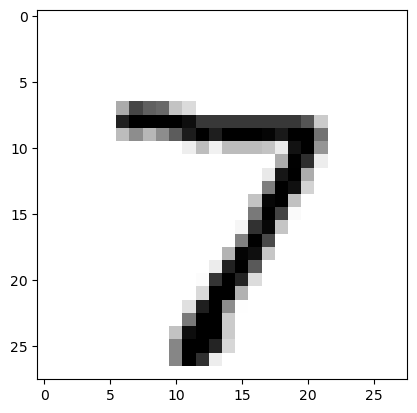

1 2 2


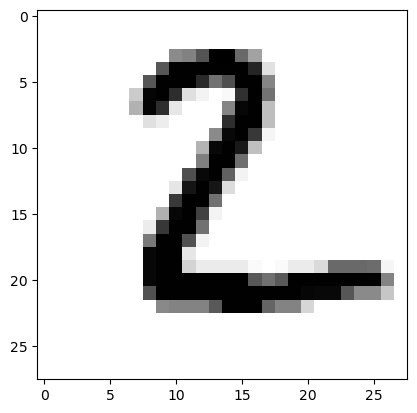

In [37]:
# 3 images from the test data that your network predicts incorrectly. Print the correct and the predicted labels.

# look up which images are wrongly labelld first
predictions = model.predict(x_test)
for img in range(2):
    hottest = np.argmax(predictions[img])   # the highest probability one
    print(img, l_test[img], hottest)
    plt.imshow(x_test[img], cmap=plt.cm.binary)
    plt.show()

In [ ]:
'''
I looked up the first 20 images and I found image No. 8, 15, 18a have mistakes 
(image No starts from 0). Below are those images, and the correct and predicted labels.
'''

for img in [8, 15, 18]:
    hottest = np.argmax(predictions[img])
    print('label: {:d}, prediction: {:d}'.format(l_test[img], hottest))
    plt.imshow(x_test[img], cmap=plt.cm.binary)
    plt.show()

In [ ]:
import collections

test_accuracy = collections.OrderedDict(sorted(test_accuracy.items()))
train_accuracy = collections.OrderedDict(sorted(train_accuracy.items()))
plt.semilogx(train_accuracy.keys(), train_accuracy.values(), 'ro', linestyle='solid', \
             label='training accuracy')
plt.semilogx(test_accuracy.keys(), test_accuracy.values(), 'bo', linestyle='solid', \
             label='test accuracy')
plt.xlabel('training size')
plt.ylabel('accuracy')
plt.title('compare training accuracy and test accuracy')
plt.legend()

## Key functions called by `fits.read_sky_map`

In [ ]:
imshow_hpx(self, data)
    img = self._reproject_hpx(data, ...)
_reproject_hpx(self, data)
    img, mask = reproject_from_healpix(data, self.header)
reproject_from_healpix(input_data, output_projection, ...) # output_projection = self.header
    parse_input_healpix_data
    parse_output_projection
    return healpix_to_image()
healpix_to_image(array_in, coord_system_in, ...)
    if order == 1:
        data = hp.interpolate_bilinear_lonlat(...)
    elif order == 0:
        data = healpix_data[ipix]

In [ ]:
def imshow_hpx(self, data, hdu_in=None, order='bilinear', nested=False,
               field=0, smooth=None, **kwargs):
    """Add an image for a HEALPix data set.
    Parameters
    ----------
    data : `numpy.ndarray` or str or `~astropy.io.fits.TableHDU` or 
        `~astropy.io.fits.BinTableHDU` or tuple
        The HEALPix data set. If this is a `numpy.ndarray`, then it is
        interpreted as the HEALPix array in the same coordinate system as
        the axes. Otherwise, the input data can be any type that is
        understood by `reproject.reproject_from_healpix`.
    smooth : `astropy.units.Quantity`, optional
        An optional smoothing length in angle-compatible units.
    Other parameters
    ----------------
    hdu_in, order, nested, field, smooth :
        Extra arguments for `reproject.reproject_from_healpix`
    kwargs :
        Extra keyword arguments for `matplotlib.axes.Axes.contour`
    Returns
    -------
    image : `matplotlib.image.AxesImage`
    """  # noqa: E501
    img = self._reproject_hpx(data, hdu_in=hdu_in, order=order,
                              nested=nested, field=field, smooth=smooth)
    return self.imshow(img, **kwargs)

In [ ]:
def _reproject_hpx(self, data, hdu_in=None, order='bilinear',
                   nested=False, field=0, smooth=None):
    if isinstance(data, np.ndarray):
        data = (data, self.header['RADESYS'])

    # It's normal for reproject_from_healpix to produce some Numpy invalid
    # value warnings for points that land outside the projection.
    with np.errstate(invalid='ignore'):
        img, mask = reproject_from_healpix(
            data, self.header, hdu_in=hdu_in, order=order, nested=nested,
            field=field)
    img = np.ma.array(img, mask=~mask.astype(bool))

    if smooth is not None:
        # Infrequently used imports
        from astropy.convolution import convolve_fft, Gaussian2DKernel

        pixsize = np.mean(np.abs(self.wcs.wcs.cdelt)) * u.deg
        smooth = (smooth / pixsize).to(u.dimensionless_unscaled).value
        kernel = Gaussian2DKernel(smooth)
        # Ignore divide by zero warnings for pixels that have no valid
        # neighbors.
        with np.errstate(invalid='ignore'):
            img = convolve_fft(img, kernel, fill_value=np.nan)

    return img

In [ ]:
def reproject_from_healpix(input_data, output_projection, shape_out=None,
                           hdu_in=1, order='bilinear', nested=None,
                           field=0):
    """
    Reproject data from a HEALPIX projection to a standard projection.
    Parameters
    ----------
    input_data
        The input data to reproject. This can be:
            * The name of a HEALPIX FITS file
            * A `~astropy.io.fits.TableHDU` or `~astropy.io.fits.BinTableHDU`
              instance
            * A tuple where the first element is a `~numpy.ndarray` and the
              second element is a `~astropy.coordinates.BaseCoordinateFrame`
              instance or a string alias for a coordinate frame.
    output_projection : `~astropy.wcs.WCS` or `~astropy.io.fits.Header`
        The output projection, which can be either a `~astropy.wcs.WCS`
        or a `~astropy.io.fits.Header` instance.
    shape_out : tuple, optional
        If ``output_projection`` is a `~astropy.wcs.WCS` instance, the
        shape of the output data should be specified separately.
    hdu_in : int or str, optional
        If ``input_data`` is a FITS file, specifies the HDU to use.
        (the default HDU for HEALPIX data is 1, unlike with image files where
        it is generally 0)
    order : int or str, optional
        The order of the interpolation (if ``mode`` is set to
        ``'interpolation'``). This can be either one of the following strings:
            * 'nearest-neighbor'
            * 'bilinear'
        or an integer. A value of ``0`` indicates nearest neighbor
        interpolation.
    nested : bool, optional
        The order of the healpix_data, either nested (True) or ring (False).
        If a FITS file is passed in, this is determined from the header.
    field : int, optional
        The column to read from the HEALPIX FITS file. If the fits file is a
        partial-sky file, field=0 corresponds to the first column after the
        pixel index column.
    Returns
    -------
    array_new : `~numpy.ndarray`
        The reprojected array
    footprint : `~numpy.ndarray`
        Footprint of the input array in the output array. Values of 0 indicate
        no coverage or valid values in the input image, while values of 1
        indicate valid values.
    """

    array_in, coord_system_in, nested = parse_input_healpix_data(input_data, hdu_in=hdu_in,
                                                                 field=field, nested=nested)
    wcs_out, shape_out = parse_output_projection(output_projection, shape_out=shape_out)

    if nested is None:
        raise ValueError("Could not determine whether the data follows the "
                         "'ring' or 'nested' ordering, so you should set "
                         "nested=True or nested=False explicitly.")

    return healpix_to_image(array_in, coord_system_in, wcs_out, shape_out,
                            order=order, nested=nested)

In [ ]:
def healpix_to_image(healpix_data, coord_system_in, wcs_out, shape_out,
                     order='bilinear', nested=False):
    """
    Convert image in HEALPIX format to a normal FITS projection image (e.g.
    CAR or AIT).
    Parameters
    ----------
    healpix_data : `numpy.ndarray`
        HEALPIX data array
    coord_system_in : str or `~astropy.coordinates.BaseCoordinateFrame`
        The coordinate system for the input HEALPIX data, as an Astropy
        coordinate frame or corresponding string alias (e.g. ``'icrs'`` or
        ``'galactic'``)
    wcs_out : `~astropy.wcs.WCS`
        The WCS of the output array
    shape_out : tuple
        The shape of the output array
    order : int or str, optional
        The order of the interpolation (if ``mode`` is set to
        ``'interpolation'``). This can be either one of the following strings:
            * 'nearest-neighbor'
            * 'bilinear'
        or an integer. A value of ``0`` indicates nearest neighbor
        interpolation.
    nested : bool
        The order of the healpix_data, either nested or ring.  Stored in
        FITS headers in the ORDERING keyword.
    Returns
    -------
    reprojected_data : `numpy.ndarray`
        HEALPIX image resampled onto the reference image
    footprint : `~numpy.ndarray`
        Footprint of the input array in the output array. Values of 0 indicate
        no coverage or valid values in the input image, while values of 1
        indicate valid values.
    """

    healpix_data = np.asarray(healpix_data, dtype=float)

    # Look up lon, lat of pixels in reference system and convert celestial coordinates
    yinds, xinds = np.indices(shape_out)
    world_in = wcs_out.pixel_to_world(xinds, yinds).transform_to(coord_system_in)
    world_in_unitsph = world_in.represent_as('unitspherical')
    lon_in, lat_in = world_in_unitsph.lon, world_in_unitsph.lat

    if isinstance(order, str):
        order = ORDER[order]

    nside = npix_to_nside(len(healpix_data))

    hp = HEALPix(nside=nside, order='nested' if nested else 'ring')

    if order == 1:
        data = hp.interpolate_bilinear_lonlat(lon_in, lat_in, healpix_data)
    elif order == 0:
        ipix = hp.lonlat_to_healpix(lon_in, lat_in)
        data = healpix_data[ipix]
    else:
        raise ValueError("Only nearest-neighbor and bilinear interpolation are supported")

    footprint = np.ones(data.shape, bool)

    return data, footprint